In [1]:
import numpy as np
import sklearn as sk
from time import time
from sklearn import metrics

In [2]:
# Fetch Train and Test dataset
train = np.genfromtxt("/content/drive/MyDrive/netflix/TrainingRatings.txt", delimiter=",")
test = np.genfromtxt("/content/drive/MyDrive/netflix/TestingRatings.txt", delimiter=",")

In [3]:
# get all the unique movies and users from both test and train to create matrix
uniqMovies = np.union1d(np.unique(train[:, 0]), np.unique(test[:, 0])).astype(int)
print(uniqMovies.shape)
testUsers = np.unique(test[:, 1].astype(int))
trainUsers = np.unique(train[:, 1].astype(int))
# uniqUsers = np.union1d(, np.unique(test[:, 1].astype(int))).astype(int)
print(testUsers.shape)
print(trainUsers.shape)

(1821,)
(27555,)
(28978,)


In [4]:
# get all the stored users i.e train users average ratings
stored_user_avg_ratings = {}
for movie_id, user_id, rating in train:
    stored_user_avg_ratings.setdefault(int(user_id), [])
    stored_user_avg_ratings[int(user_id)].append(rating)

for user_id in stored_user_avg_ratings:
    stored_user_avg_ratings[int(user_id)] = np.mean(stored_user_avg_ratings[int(user_id)])

# get all the active users i.e test users average ratings
active_user_avg_ratings = {}
for movie_id, user_id, rating in test:
    active_user_avg_ratings.setdefault(int(user_id), [])
    active_user_avg_ratings[int(user_id)].append(rating)

for user_id in active_user_avg_ratings:
    active_user_avg_ratings[int(user_id)] = np.mean(active_user_avg_ratings[int(user_id)])
print(len(active_user_avg_ratings))

27555


In [5]:
# create a matrix for stored users i.e Train m x n => (users x movies) => (28978 x 1821)
# FOR CRYING OUT LOUD USE FLOAT32 EVERYWHERE
stored_mappings = np.zeros((trainUsers.shape[0],uniqMovies.shape[0]), dtype='f')
for movie_id, user_id, rating in train:
  movInd = np.where(uniqMovies == int(movie_id))[0][0]
  userInd = np.where(trainUsers == int(user_id))[0][0]
  stored_mappings[userInd, movInd] = rating - stored_user_avg_ratings[int(user_id)]
print(stored_mappings.shape)

# create a matrix for active users i.e Test m x n => (users x movies) => (28978 x 1821)
active_mappings = np.zeros((testUsers.shape[0],uniqMovies.shape[0]), dtype='f')
for movie_id, user_id, rating in test:
  movInd = np.where(uniqMovies == int(movie_id))[0][0]
  userInd = np.where(testUsers == int(user_id))[0][0]
  active_mappings[userInd, movInd] = rating - active_user_avg_ratings[int(user_id)]
print(active_mappings.shape)

(28978, 1821)
(27555, 1821)


In [6]:
# from sklearn.metrics.pairwise import pairwise_distances
# from scipy.spatial.distance import correlation
# # FOR CRYING OUT LOUD USE FLOAT32 EVERYWHERE
# weight = pairwise_distances(stored_mappings, active_mappings, metric='correlation', dtype='f') 
# print(weight.shape)

# FOR CRYING OUT LOUD USE FLOAT32 EVERYWHERE
weight = np.matmul(stored_mappings, active_mappings.T,dtype='f')
print(weight.shape)

(28978, 27555)


In [7]:
# working out the denominator
stored_square = stored_mappings ** 2
active_square = active_mappings ** 2

In [8]:
# sum all the squares 
stored_sum = stored_square.sum(axis=1)[:, np.newaxis]
active_sum = active_square.sum(axis=1)[:, np.newaxis]
print("stored_sum: ", stored_sum.shape)
print("active_sum: ", active_sum.shape)
# print(stored_sum.shape, active_sum.shape)
each_row_sqrt = np.sqrt(np.matmul(stored_sum, active_sum.T))
print(each_row_sqrt)

stored_sum:  (28978, 1)
active_sum:  (27555, 1)
[[ 0.       13.786839 13.786839 ...  0.       16.478424 15.91967 ]
 [ 0.       13.081248 13.081248 ...  0.       15.635082 15.104924]
 [ 0.        8.458682  8.458682 ...  0.       10.110059  9.767244]
 ...
 [ 0.       12.641102 12.641102 ...  0.       15.109007 14.596687]
 [ 0.       12.978616 12.978616 ...  0.       15.512413 14.986415]
 [ 0.       14.557579 14.557579 ...  0.       17.399635 16.809645]]


In [9]:
# all weights
weight = np.divide(weight, each_row_sqrt, dtype='f')
print(weight.shape)
del each_row_sqrt

(28978, 27555)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [10]:
users_avg_ratings = [0.0] * trainUsers.shape[0]
for stored in stored_user_avg_ratings:
  userInd = np.where(trainUsers == int(user_id))[0][0]
  users_avg_ratings[userInd] = stored_user_avg_ratings[stored]

In [11]:
weight = np.nan_to_num(weight, False)
ENABLE_CASE_AMPLIFICATION = False
if ENABLE_CASE_AMPLIFICATION:
  for row in range(weight.shape[0]):
    weight[row, :] = np.where(weight[row, :] >=0, np.power(weight[row, :], 2.5), -np.power(-weight[row, :], 2.5))

In [12]:
y_pred = []
y_true = []
for i, (movie_id, user_id, rating) in enumerate(test):
    userInd = np.where(testUsers == int(user_id))[0][0]
    movInd = np.where(uniqMovies == int(movie_id))[0][0]
    from_stored = np.sum(weight[:, userInd] * users_avg_ratings) / np.sum(np.abs(weight[:, userInd]))
    if np.isnan(from_stored):
        from_stored = 0
    prob = active_user_avg_ratings[int(user_id)] + from_stored

    y_pred.append(prob)
    y_true.append(rating)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [13]:
print(metrics.accuracy_score(y_true,[round(y) for y in y_pred]) * 100)
print(metrics.mean_squared_error(y_true,y_pred))
print(metrics.mean_absolute_error(y_true,y_pred))
print(metrics.confusion_matrix(y_true, [round(y) for y in y_pred], labels=[1, 2, 3, 4, 5]))

47.77662771950079
0.7031268691066797
0.6388055448889984
[[  602  2001  2385   367     1]
 [   48  2745  6884  1768     2]
 [   23  2003 19228 11120    86]
 [    4   594 10004 20350  1144]
 [    3   118  2716 11202  5080]]


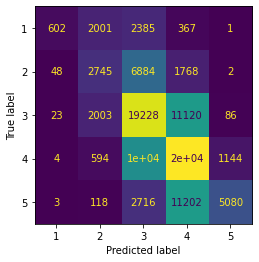

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(y_true, [round(y) for y in y_pred], labels=[1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(colorbar=False)
plt.show()